In [1]:
from fastai.vision.all import *
from torchvision.datasets import CIFAR10
import timm
from autoattack import AutoAttack

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [2]:
# Function to prepare DataLoaders
def get_dls(bs, size):
    dset = CIFAR10('.', train=True, download=True)
    dset_test = CIFAR10('.', train=False, download=True)
    names = dset_test.classes

    x_train, y_train = zip(*[(x, names[y]) for x, y in dset])
    x_test, y_test = zip(*[(x, names[y]) for x, y in dset_test])

    # Using fastai's DataBlock to create data loaders
    cifar = DataBlock(blocks=(ImageBlock, CategoryBlock(vocab=names)),
                      getters=[ItemGetter(0), ItemGetter(1)],
                      splitter=RandomSplitter(valid_pct=0.2, seed=42),
                      item_tfms=Resize(size),
                      batch_tfms=aug_transforms(min_scale=0.75) + [Normalize.from_stats(*imagenet_stats)])
    dls = cifar.dataloaders(list(zip(x_train, y_train)), batch_size=bs)
    dls_test = dls.test_dl(list(zip(x_test, y_test)), with_labels=True, shuffle=False)
    return dls, dls_test

# Create DataLoaders
dls, dls_test = get_dls(128, 128)

# Custom function to load and modify the timm model
def timm_model(arch, n_out, pretrained=True):
    model = timm.create_model(arch, pretrained=pretrained, num_classes=n_out)
    return model

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Define the learner
learn = Learner(dls, timm_model('tf_efficientnetv2_s.in21k_ft_in1k', dls.c, pretrained=True), metrics=accuracy)

SuggestedLRs(valley=0.0006918309954926372)

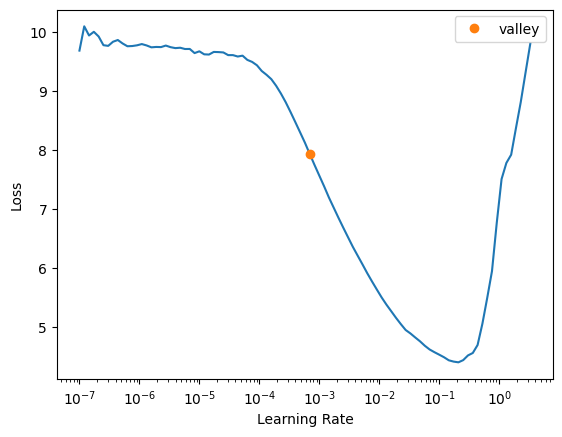

In [23]:
learn.lr_find()

In [35]:
learn.dls = dls

In [36]:
# Training the model
learn.fine_tune(10, base_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.547397,0.422742,0.875200,00:25


epoch,train_loss,valid_loss,accuracy,time
0,0.307415,0.356334,0.888500,00:24
1,0.253605,0.308618,0.902500,00:24
2,0.190244,0.272553,0.915100,00:24
3,0.158709,0.256713,0.922300,00:24
4,0.130801,0.240894,0.926600,00:24
5,0.107832,0.237115,0.930200,00:24
6,0.098246,0.237954,0.930800,00:26
7,0.088612,0.238306,0.933400,00:26
8,0.085878,0.234324,0.932400,00:25
9,0.085732,0.238373,0.932600,00:26


In [26]:
learn.fit_one_cycle(10, lr_max=2e-5, pct_start=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.005347,0.107096,0.973200,00:55
1,0.005150,0.110222,0.972500,00:55
2,0.005869,0.111549,0.973200,00:54
3,0.004626,0.109681,0.973600,00:54
4,0.005206,0.113852,0.973000,00:54
5,0.003796,0.111316,0.972800,00:53
6,0.003020,0.112146,0.973300,00:55
7,0.003050,0.114004,0.972800,00:55
8,0.004927,0.112337,0.973100,00:53
9,0.004077,0.112178,0.972700,00:55


In [8]:
#learn.save('efn_t0')

Path('models/efn_t0.pth')

In [4]:
learn.load('efn_s128')

In [5]:
model = learn.model.cuda()
model.eval()
model.children

<bound method Module.children of EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
     

In [37]:
list(model.children())[-5]

Sequential(
  (0): Sequential(
    (0): ConvBnAct(
      (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (drop_path): Identity()
    )
    (1): ConvBnAct(
      (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (drop_path): Identity()
    )
  )
  (1): Sequential(
    (0): EdgeResidual(
      (conv_exp): Conv2dSame(24, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNormAct2d(
        96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (se): Identity()
 

In [39]:
list(list(model.children())[-5].children())[-1]

Sequential(
  (0): InvertedResidual(
    (conv_pw): Conv2d(160, 960, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (conv_dw): Conv2dSame(960, 960, kernel_size=(3, 3), stride=(2, 2), groups=960, bias=False)
    (bn2): BatchNormAct2d(
      960, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (se): SqueezeExcite(
      (conv_reduce): Conv2d(960, 40, kernel_size=(1, 1), stride=(1, 1))
      (act1): SiLU(inplace=True)
      (conv_expand): Conv2d(40, 960, kernel_size=(1, 1), stride=(1, 1))
      (gate): Sigmoid()
    )
    (conv_pwl): Conv2d(960, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNormAct2d(
      256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Identity()

In [6]:
class OpenedNet(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        original = list(original_model.children())
        # Everything except the final linear layer
        self.features = nn.Sequential(*original[:-4])
        self.pools = nn.Sequential(*original[-4:-1])
        # The last linear layer
        self.classifier = list(original_model.children())[-1]
    
    def forward(self, x):
        # Forward pass until the last layer
        last_grid = self.features(x)
        last_activation = self.pools(last_grid)
        out = self.classifier(last_activation)
        return last_grid, last_activation, out

In [7]:
learn.validate(dl=dls_test)

(#2) [0.14861129224300385,0.970300018787384]

In [8]:
on = OpenedNet(model)
on.eval();

In [9]:
a = next(iter(dls_test))

In [12]:
with torch.no_grad():
  outs = on(a[0])
  final = outs[-1]
  final_orig = model(a[0])
torch.all(final == final_orig)

TensorImage(True, device='cuda:0')

In [49]:
outs[0].shape

torch.Size([128, 256, 4, 4])

In [10]:
def update_statistics(old_mean, old_cov, old_count, new_data):
    new_mean = torch.mean(new_data, dim=0)
    new_count = new_data.size(0)
    mean_diff = new_mean - old_mean
    demeaned_new_data = new_data - new_mean
    new_cov = torch.mm(demeaned_new_data.t(), demeaned_new_data) / (new_count - 1)
    total_count = old_count + new_count
    new_weighted_mean = old_mean + mean_diff * (new_count / total_count)
    new_weighted_cov = (old_cov * (old_count - 1) + new_cov * (new_count - 1) +
                        torch.outer(mean_diff, mean_diff) * (old_count * new_count / total_count)) / (total_count - 1)
    return new_weighted_mean, new_weighted_cov, total_count

def extract_patches(feature_maps, kernel_size=3):
    """ Extracts sliding window patches from the feature maps. """
    batch_size, channels, height, width = feature_maps.shape
    patches = feature_maps.unfold(2, kernel_size, 1).unfold(3, kernel_size, 1)
    patches = patches.contiguous().view(batch_size, channels, -1, kernel_size * kernel_size)
    patches = patches.permute(0, 2, 1, 3).contiguous().view(-1, channels * kernel_size * kernel_size)
    return patches

def mahalanobis_distance(x, mean, cov_inv):
    delta = x - mean
    m_distance = torch.sqrt(torch.sum(delta @ cov_inv * delta, dim=1))
    return m_distance

In [13]:
ver = [extract_patches(outs[0]), outs[1]]
counts = [0 for o in ver]
means = [torch.zeros(o.shape[-1], device=o.device) for o in ver]
covs = [torch.zeros((o.shape[-1], o.shape[-1]), device=o.device) for o in ver]

with torch.no_grad():
  for x, y in dls.train:
    outs = on(x)
    ver = [extract_patches(outs[0]), outs[1]]
    for i, v in enumerate(ver):
      means[i], covs[i], counts[i] = update_statistics(means[i], covs[i], counts[i], v)

In [119]:
dists[0].shape

torch.Size([40000])

In [14]:
invs = [torch.linalg.inv(c) for c in covs]
dists = [[] for i in ver]
with torch.no_grad():
  for x, y in dls.valid:
    outs = on(x)
    ver = [extract_patches(outs[0]), outs[1]]
    for i, v in enumerate(ver):
      dists[i].append(mahalanobis_distance(v, means[i], invs[i]).cpu())
dists = [torch.cat(d) for d in dists]

In [13]:
mahalanobis_distance(ver[1], means[1], invs[1])

TensorImage([35.3224, 30.7872, 38.3805, 37.0629, 38.0070, 38.4007, 41.3379,
             63.1384, 33.8511, 31.2999, 33.5421, 59.8319, 28.1929, 41.3702,
             36.8082, 28.6113], device='cuda:0')

In [14]:
dists2 = [dists[0].reshape(-1, 4).mean(dim=-1), dists[1]]

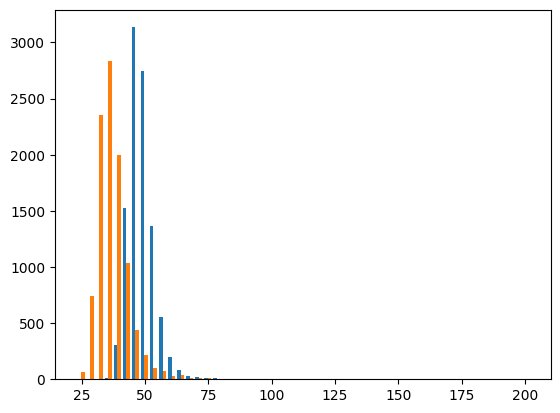

In [15]:
plt.hist(dists2, bins=50);

In [19]:
distst = [[] for i in ver]
with torch.no_grad():
  for x, y in dls_test:
    outs = on(x)
    ver = [extract_patches(outs[0]), outs[1]]
    for i, v in enumerate(ver):
      distst[i].append(mahalanobis_distance(v, means[i], invs[i]).cpu())
distst = [torch.cat(d) for d in distst]
distst2 = [distst[0].reshape(-1, 4).mean(dim=-1), distst[1]]

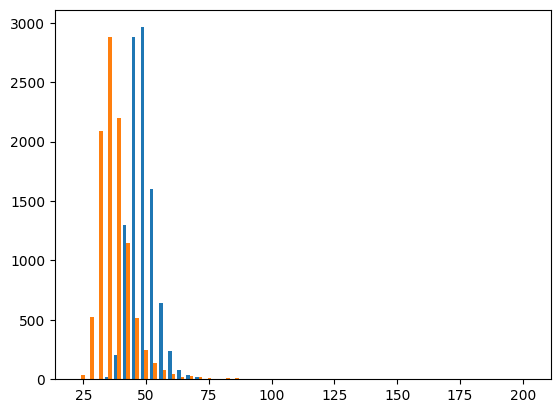

In [17]:
plt.hist(distst2, bins=50);

In [254]:
adversary = AutoAttack(model.cuda(), norm='Linf', eps=0.1, version='standard')
adversary.apgd.n_restarts = 1  # Customize based on your needs

# Function to process batches from FastAI DataLoader
def get_adv_examples(dl):
    model.eval()
    adv_examples = []
    i = 0
    for xb, yb in dl:
        print(xb.shape)
        xb, yb = Tensor(xb), Tensor(yb)
        x_adv = adversary.run_standard_evaluation(xb, yb, bs=xb.size(0))
        adv_examples.append(x_adv.cpu())
        i+=1
        if i>=1:
          break
    return adv_examples

# Generate adversarial examples
adv_examples = get_adv_examples(dls_test)

setting parameters for standard version
torch.Size([128, 3, 128, 128])
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 95.31%
apgd-ce - 1/1 - 122 out of 122 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 8.1 s)
max Linf perturbation: 2.11790, nan in tensor: 0, max: 2.64000, min: -2.11790
robust accuracy: 0.00%


In [95]:
# torch.save(torch.cat(adv_examples), 'adv_examples')

In [15]:
adv_examples = torch.load('adv_examples')

In [16]:
examples = next(iter(dls_test))[0].cpu()
examples

TensorImage([[[[ 0.5878,  0.5878,  0.5878,  ..., -0.1143, -0.1314, -0.1314],
               [ 0.5878,  0.5878,  0.5878,  ..., -0.1143, -0.1314, -0.1314],
               [ 0.5707,  0.5707,  0.5707,  ..., -0.1143, -0.1314, -0.1314],
               ...,
               [-1.1760, -1.1760, -1.1760,  ..., -1.7240, -1.7583, -1.7583],
               [-1.1932, -1.1932, -1.1932,  ..., -1.7240, -1.7583, -1.7583],
               [-1.1932, -1.1932, -1.1932,  ..., -1.7240, -1.7583, -1.7583]],

              [[-0.0749, -0.0749, -0.0749,  ..., -0.5301, -0.5476, -0.5476],
               [-0.0749, -0.0749, -0.0749,  ..., -0.5301, -0.5476, -0.5476],
               [-0.0749, -0.0749, -0.0749,  ..., -0.5301, -0.5476, -0.5476],
               ...,
               [-0.1450, -0.1450, -0.1450,  ..., -0.8277, -0.8627, -0.8627],
               [-0.1625, -0.1625, -0.1625,  ..., -0.8277, -0.8627, -0.8627],
               [-0.1625, -0.1625, -0.1625,  ..., -0.8277, -0.8627, -0.8627]],

              [[-0.9504, -0.9504

In [21]:
torch.linalg.norm(examples[:100] - adv_examples[0][:100])

TensorImage(2591.4712)

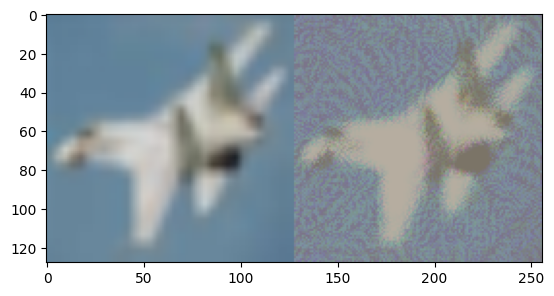

In [22]:
mean = torch.tensor(imagenet_stats[0])
std = torch.tensor(imagenet_stats[1])
i = 10
img_norm_adv = adv_examples[i] * std[:, None, None] + mean[:, None, None]
img_norm = examples[i] * std[:, None, None] + mean[:, None, None]
plt.imshow(torch.hstack([(img_norm*255).to(int).permute(1, 2, 0).clip(0, 255), 
                        (img_norm_adv*255).to(int).permute(1, 2, 0).clip(0, 255)]))

In [23]:
torch.cat(adv_examples).max()

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [257]:
(examples).max()

TensorImage(2.6400)

tensor([[[175, 145, 169,  ..., 123, 129, 131],
         [175, 159, 175,  ..., 128, 133, 123],
         [168, 171, 153,  ..., 133, 129, 123],
         ...,
         [123, 123, 123,  ..., 123, 123, 123],
         [123, 123, 123,  ..., 123, 123, 123],
         [123, 123, 123,  ..., 123, 123, 123]],

        [[128, 118, 129,  ..., 116, 116, 116],
         [129, 129, 122,  ..., 116, 116, 116],
         [123, 118, 121,  ..., 116, 116, 116],
         ...,
         [122, 119, 118,  ..., 116, 116, 116],
         [116, 123, 121,  ..., 116, 116, 116],
         [123, 117, 117,  ..., 116, 116, 116]],

        [[103, 103, 103,  ..., 103, 103, 103],
         [103, 103, 103,  ..., 103, 103, 103],
         [103, 103, 103,  ..., 103, 103, 103],
         ...,
         [158, 154, 153,  ..., 117, 127, 123],
         [150, 143, 145,  ..., 122, 103, 105],
         [145, 142, 158,  ..., 105, 103, 105]]])

In [126]:
adv_examples

tensor([[[[8.8386e-01, 3.7017e-01, 7.8364e-01,  ..., 3.8619e-03,
           9.2505e-02, 1.3308e-01],
          [8.8781e-01, 6.1122e-01, 8.8363e-01,  ..., 8.0737e-02,
           1.6435e-01, 0.0000e+00],
          [7.7192e-01, 8.2314e-01, 5.1018e-01,  ..., 1.6502e-01,
           1.0419e-01, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[2.1007e-01, 4.0173e-02, 2.2507e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.2507e-01, 2.2507e-01, 1.0159e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [1.2630e-01, 4.0466e-02, 9.0351e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.1659e-01, 6.4926e-02, 4.5022e-02,  ..., 0.0000

In [17]:
dists_adv = [[] for i in ver]
with torch.no_grad():
  outs = on(adv_examples.cuda())
  ver = [extract_patches(outs[0]), outs[1]]
  for i, v in enumerate(ver):
    dists_adv[i].append(mahalanobis_distance(v, means[i], invs[i]).cpu())
dists_adv = [torch.cat(d) for d in dists_adv]
dists_adv2 = [dists_adv[0].reshape(-1, 4).mean(dim=-1), dists_adv[1]]

In [43]:
plt.rc('text', usetex = True )
plt.rcParams.update ({ 'font.family' : 'Serif' })
plt.rcParams.update ({ 'font.size': 14})
plt.style.use("seaborn-v0_8-darkgrid")

In [21]:
distst2[0].mean(), distst2[0].std()

(TensorImage(48.6496), TensorImage(5.0322))

In [22]:
dists_adv2[0].mean(), dists_adv2[0].std()

(TensorImage(174.6002), TensorImage(83.3178))

In [30]:
t = 61
(dists_adv2[0]<t).to(torch.float32).mean(), 1-(distst2[0]<t).to(torch.float32).mean()

(TensorImage(0.0518), TensorImage(0.0191))

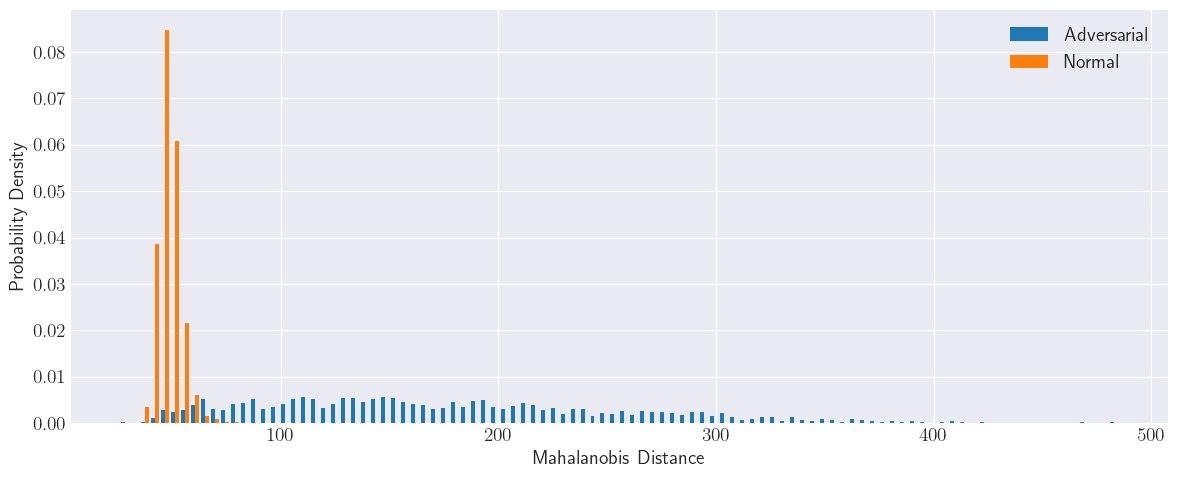

In [45]:
plt.figure(figsize=(12, 5))
plt.hist([dists_adv2[0], distst2[0]], bins=100, density=True)
plt.legend(['Adversarial', 'Normal'])
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Probability Density')
plt.tight_layout()
plt.savefig('hist-adv-det.pdf')
# plt.figure()
# plt.hist([dists_adv2[1], distst2[1]], bins=50, density=True)
# plt.legend(['Adversarial', 'Normal'])
# plt.xlabel('Mahalanobis Distance')
# plt.ylabel('Probability Density')

In [49]:
a = np.load('/home/gabriel/githubs/OpenOOD/data/benchmark_imglist/cifar10/pgd.npy')

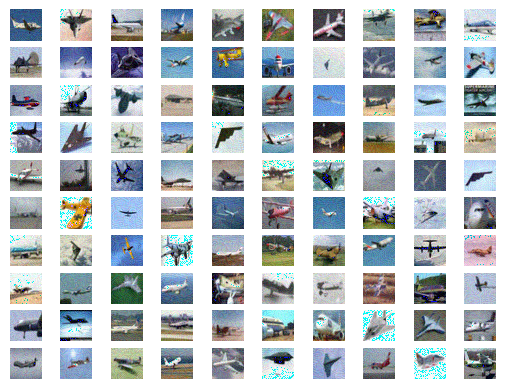

In [69]:
fig, axs = plt.subplots(10, 10)
for i in range(10):
  for j in range(10):
    axs[i][j].axis('off')
    axs[i][j].imshow(a[i*10+j], interpolation='bilinear')

In [ ]:
dists[0].unflatten(-1, 4).mean(dim=-1)

In [50]:
[d.std() for d in distst2]

[TensorImage(5.0224), TensorImage(6.9927)]

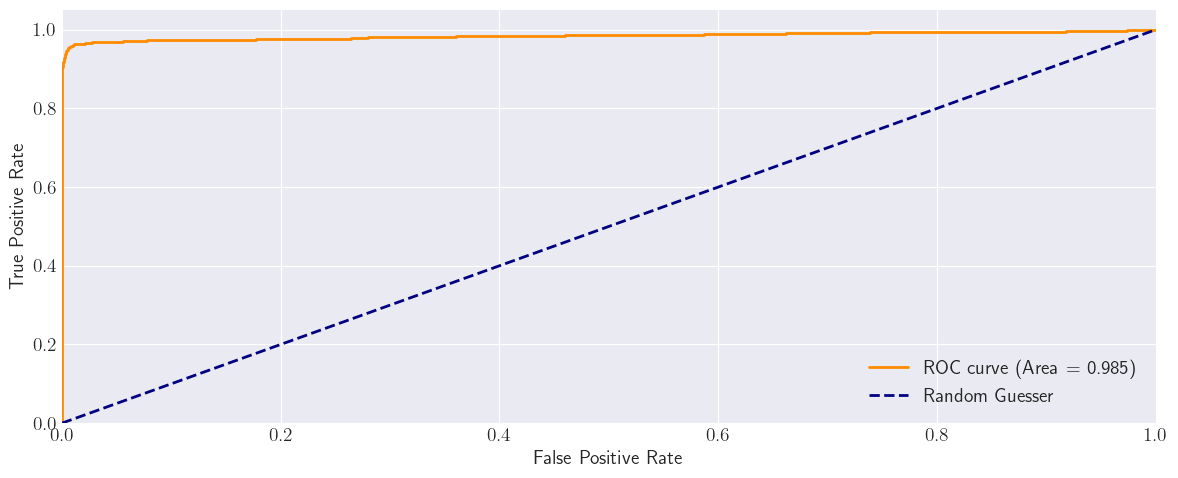

0.9847850852272727


In [48]:
normal = distst2[1]
anomaly = dists_adv2[1]

# Combine the data and create labels
data = np.concatenate([normal, anomaly])
labels = np.array([0] * len(normal) + [1] * len(anomaly))

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, data)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(12, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (Area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guesser')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc-adv-det.pdf')
plt.show()
print(roc_auc)

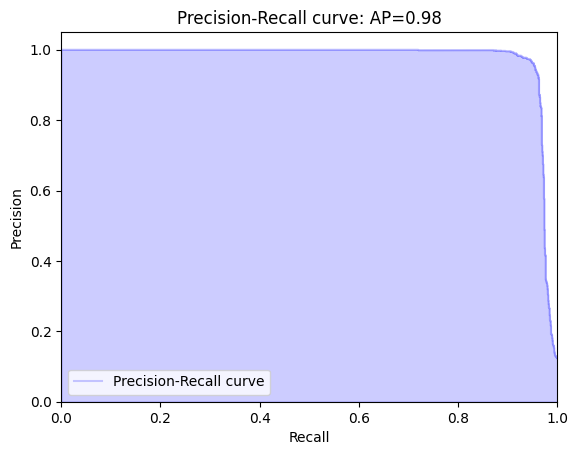

In [27]:
precision, recall, thresholds = precision_recall_curve(labels, data)
average_precision = average_precision_score(labels, data)

plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.2, label='Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()